In [ ]:
#run this when you first launch this notebook / install on ur pc laptop
!pip install dython 
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install scipy
#!pip install matplotlib
#!pip install sklearn
#!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import datasets
from dython.nominal import associations
from matplotlib import rcParams

**Can Data Science Models predict Cardiovascular disease?**

Cardiovascular disease (CVD) is the number one cause of death globally.

How do each of the variables (risk factors) affect having CVD? 

What is the correlation between variables? Can we expect any relationship? Can we expect a value for the person’s blood pressure when we know his/her age?

Based on a person’s health profile, can we predict if a person is likely to have CVD?

**Load Data**

In [ ]:
data = pd.read_csv('cardio_train.csv')
df = pd.read_csv('cardio_train.csv', delimiter=';')
print(f"The shape of the dataset is: {df.shape}")

The shape of the dataset is: (70000, 13)


In [ ]:
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
df.duplicated().any()  #check if dataset has duplicated entries


False

Observations:

*   70000 entries of data
*   No null values in dataset
*   12 columns to observe for possible factors that affect cardiovascular disease
*   No duplicated entries

**Cleaning the data**

In [ ]:
# dropping id
df = df.drop(['id'], axis = 'columns')

In [ ]:
# changing the age column into year
df['age'] = df['age'].map(lambda x: round(x/365))

In [ ]:
df.describe().T[1:]    #excluding the id column

,count,mean,std,min,25%,50%,75%,max
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0
active,70000.0,0.803729,0.397179,0.0,1.0,1.0,1.0,1.0


Min count of height is 55(cm), which is an extreme outlier.
Min count of weight is 10(kg), which is also an extreme outlier.

In [ ]:
# remove weight outliers using extreme ends of quantile
weight_min_outlier_mask = df['weight'] > df['weight'].quantile(0.005)
weight_max_outlier_mask = df['weight'] < df['weight'].quantile(0.999)
df = df[(weight_min_outlier_mask) & (weight_max_outlier_mask)]

In [ ]:
# remove height outliers using extreme ends of quantile
height_min_outlier_mask = df['height'] > df['height'].quantile(0.005)
height_max_outlier_mask = df['height'] < df['height'].quantile(0.999)
df = df[(height_min_outlier_mask) & (height_max_outlier_mask)]

Looking at other columns, Systolic blood pressure (ap_hi) is defined as pressure on blood vessels when your heart pumps blood and contracts/beats.

Diastolic blood pressure (ap_lo) is defined as the pressure when your heart relaxes between beats.

Systolic blood pressure will always be > than diastolic blood pressure, and also cannot be negative.

In [ ]:
#removing datapoints where systolic blood pressure < diatolic blood pressure
df = df[df['ap_hi'] > df['ap_lo']].reset_index(drop=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


Systolic and diatolic blood pressure are indicators of blood pressure, which can be separated into normal, higher than normal, Stage 1 Hypertension and Stage 2 Hypertension. 

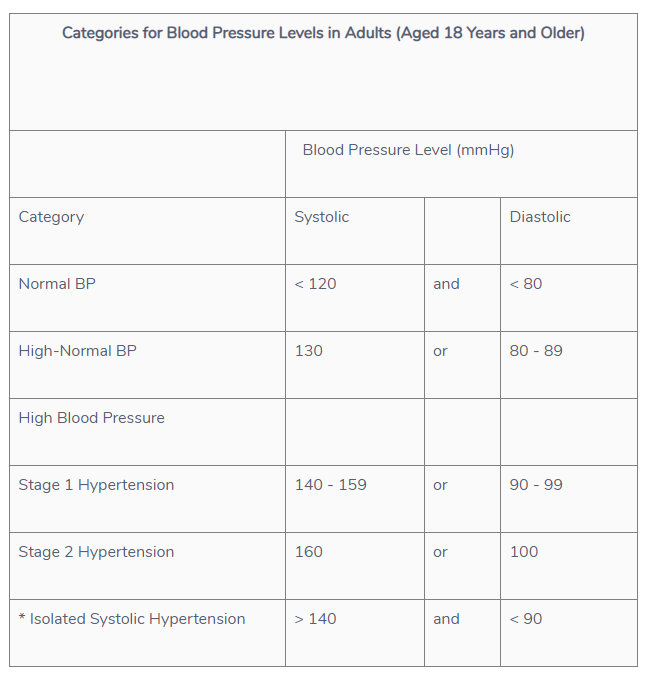

(according to https://www.healthhub.sg/a-z/diseases-and-conditions/735/Understanding-Blood-Pressure-Readings)

In [ ]:
def blood_pressure_level(data):
    if (data['ap_hi'] < 129) and (data['ap_lo'] <= 80):
        return 'Normal'
    if (data['ap_hi'] >= 130 and data['ap_hi'] <= 139) | (data['ap_lo'] > 80 and data['ap_lo'] <= 89) :
        return 'High_Normal'
    if (data['ap_hi'] >= 140 and data['ap_hi'] <= 159) | (data['ap_lo'] >= 90 and data['ap_lo'] <= 99):
        return 'Stage_1_Hypertension'
    if (data['ap_hi'] >= 160) | (data['ap_lo'] >= 100):
        return 'Stage_2_Hypertension'

df['blood_pressure_level'] = df.apply(blood_pressure_level, axis=1)
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,blood_pressure_level
0,50,2,168,62.0,110,80,1,1,0,0,1,0,Normal
1,55,1,156,85.0,140,90,3,1,0,0,1,1,Stage_1_Hypertension
2,52,1,165,64.0,130,70,3,1,0,0,0,1,High_Normal
3,48,2,169,82.0,150,100,1,1,0,0,1,1,Stage_1_Hypertension
4,48,1,156,56.0,100,60,1,1,0,0,0,0,Normal


Height and weight in isolation are not very useful factors, so combining them into BMI would be more useful

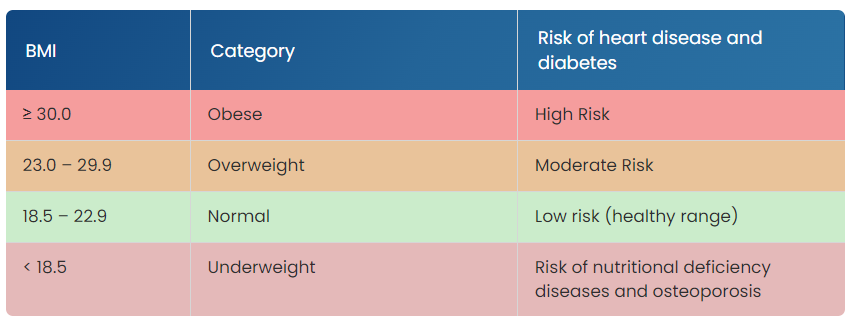

(according to https://www.myheart.org.sg/tools-resources/bmi-calculator/)

In [ ]:
#defining bmi
def BMI(data):
    return data['weight'] / (data['height']/100)**2
 
df['bmi'] = df.apply(BMI, axis=1)

In [ ]:
#adding bmi into dataframe
df['weight_category'] = df['bmi'].apply(lambda x :'Underweight' if x <= 18.5 else ('Normal' if (x > 18.5 and x <= 22.9) else ( 'Overweight' if (x > 23 and x <= 29.9) else 'Obese')) )

In [ ]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,blood_pressure_level,bmi,weight_category
0,50,2,168,62.0,110,80,1,1,0,0,1,0,Normal,21.967120,Normal
1,55,1,156,85.0,140,90,3,1,0,0,1,1,Stage_1_Hypertension,34.927679,Obese
2,52,1,165,64.0,130,70,3,1,0,0,0,1,High_Normal,23.507805,Overweight
3,48,2,169,82.0,150,100,1,1,0,0,1,1,Stage_1_Hypertension,28.710479,Overweight
4,48,1,156,56.0,100,60,1,1,0,0,0,0,Normal,23.011177,Overweight


In [ ]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000
mean,53.320866,1.351077,164.580320,74.244721,128.892902,81.278177,1.364603,1.225979,0.088434,0.053527,0.803479,0.495312,27.447471
std,6.760800,0.477311,7.569775,13.837317,156.320706,9.648790,0.679115,0.571949,0.283927,0.225083,0.397370,0.499982,5.059165
min,30.000000,1.000000,146.000000,45.800000,12.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.609204
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.346494
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.116213
max,65.000000,2.000000,189.000000,149.000000,16020.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,58.097313


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67723 entries, 0 to 67722
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   67723 non-null  int64  
 1   gender                67723 non-null  int64  
 2   height                67723 non-null  int64  
 3   weight                67723 non-null  float64
 4   ap_hi                 67723 non-null  int64  
 5   ap_lo                 67723 non-null  int64  
 6   cholesterol           67723 non-null  int64  
 7   gluc                  67723 non-null  int64  
 8   smoke                 67723 non-null  int64  
 9   alco                  67723 non-null  int64  
 10  active                67723 non-null  int64  
 11  cardio                67723 non-null  int64  
 12  blood_pressure_level  67720 non-null  object 
 13  bmi                   67723 non-null  float64
 14  weight_category       67723 non-null  object 
dtypes: float64(2), int6



*   Gender should be a category, with 1 = women, 2 = men
*   Cholesterol should be a category, with 1: normal, 2: above normal, 3: well above normal
*   Glucose should be a category, with 1: normal, 2: above normal, 3: well above normal 
*   Smoking, alcohol use, active lifestyle and presence of cardiovascular disease should all be categories





In [ ]:
#df['gender'] = df['gender'].astype('category')
#df['cholesterol'] = df['cholesterol'].astype('category')
#df['gluc'] = df['gluc'].astype('category')
#df['smoke'] = df['smoke'].astype('category')
#df['alco'] = df['alco'].astype('category')
#df['active'] = df['active'].astype('category')
#df['cardio'] = df['cardio'].astype('category')
#df['blood_pressure_level'] = df['blood_pressure_level'].astype('category')
#df['weight_category'] = df['weight_category'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67723 entries, 0 to 67722
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   67723 non-null  int64  
 1   gender                67723 non-null  int64  
 2   height                67723 non-null  int64  
 3   weight                67723 non-null  float64
 4   ap_hi                 67723 non-null  int64  
 5   ap_lo                 67723 non-null  int64  
 6   cholesterol           67723 non-null  int64  
 7   gluc                  67723 non-null  int64  
 8   smoke                 67723 non-null  int64  
 9   alco                  67723 non-null  int64  
 10  active                67723 non-null  int64  
 11  cardio                67723 non-null  int64  
 12  blood_pressure_level  67720 non-null  object 
 13  bmi                   67723 non-null  float64
 14  weight_category       67723 non-null  object 
dtypes: float64(2), int6

**Basic Uni-Variate Exploratory Analysis of Data**



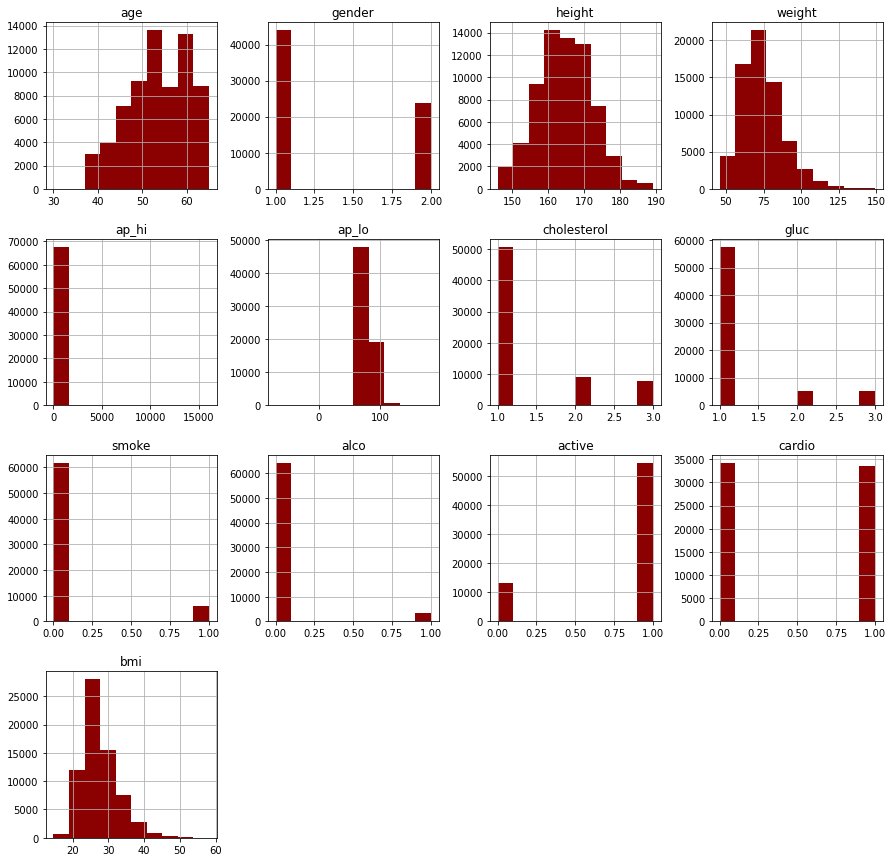

In [ ]:
df.hist(figsize = (15, 15),color = 'darkred')
plt.show()

Looking at individual variables,

Dataset is balanced, since presence of cardiovascular disease is roughly equal

For certain variables, such as presence of smoking, presence of alcohol consumption, the datasets are disproportionate and might not be sufficient to withold bias. Data also not necessarily precise, with just presence of smoking vs presence of alcohol consumption, and not frequency of smoking and frequency of alcohol consumption, but data is already disproportionate for these factors so frequency

Categorical variables naturally have dissonance between values because they are interpreted as integers

Effect of Age on Presence of Cardiovascular disease

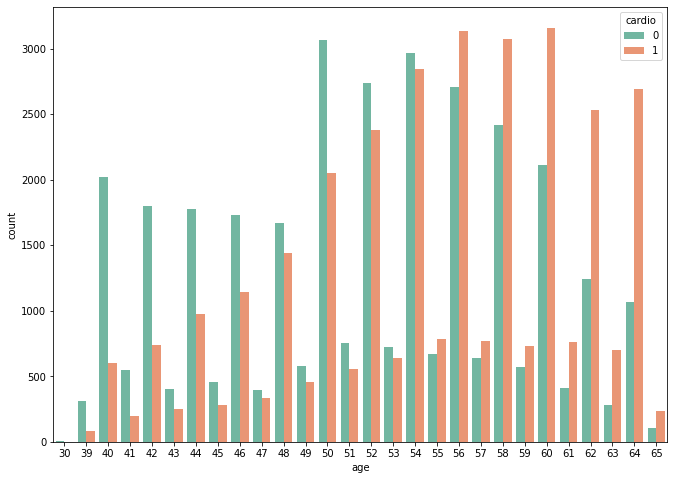

In [ ]:
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='age', hue='cardio', data = df, palette="Set2");

**How do each of the factors affect the presence of cardiovascular disease?**

**What is the correlation between variables?**

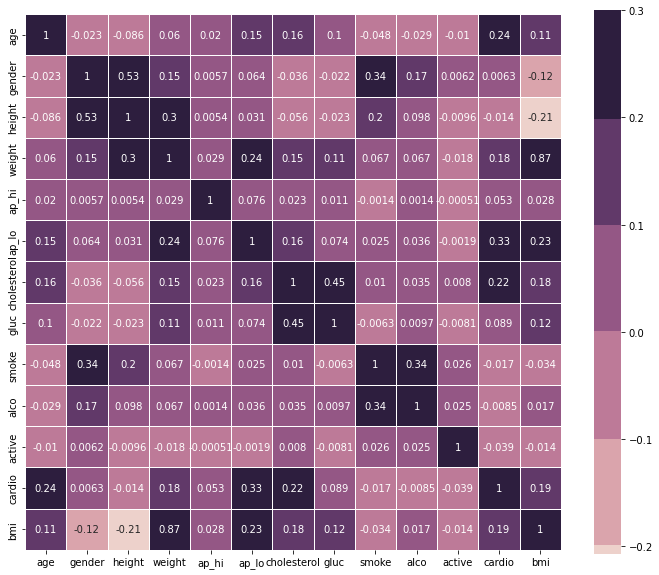

In [ ]:
  df.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, linewidths=0.5, square=True, vmax=0.3, center=0, cmap=sns.cubehelix_palette())
plt.savefig('heat.png')

As observed from the correlation matrix, the factors with the highest correlation with presence of cardiovascular disease are (ranked)

1.   Diatolic blood pressure (ap_lo) : 0.33
2.   Age : 0.24
3.   Cholesterol : 0.22
4.   BMI: 0.19
5.   Weight: 0.18



The correlation matrixes for categorical variables can also be analysed, with a dython library, using Pearson’s R for continuous-continuous cases, Correlation Ratio for categorical-continuous cases, Cramer’s V or Theil’s U for categorical-categorical cases.

In [ ]:
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(df)
categorical_features

['blood_pressure_level', 'weight_category']

Since we are focusing on categorical-continuous variables, we only look at Correlation ratio for cardiovascular disease correlation with the 2 new categorical variables as above.

η
=
√
∑
x
n
x
(
¯
y
x
−
¯
y
)
2
∑
x
,
i
(
y
x
i
−
¯
y
)
2


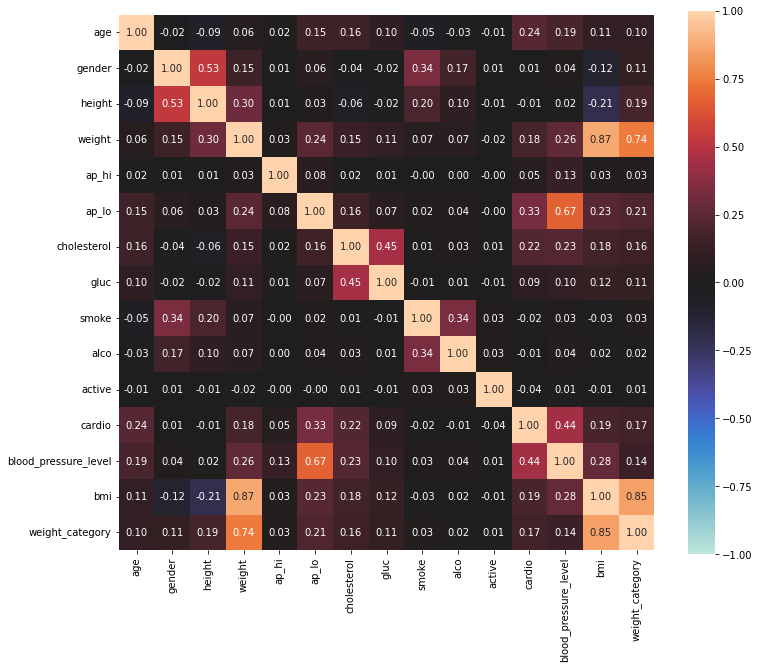

{'corr':                            age    gender    height    weight     ap_hi  \
 age                   1.000000 -0.022577 -0.085598  0.059755  0.020022   
 gender               -0.022577  1.000000  0.526201  0.150260  0.005715   
 height               -0.085598  0.526201  1.000000  0.297281  0.005373   
 weight                0.059755  0.150260  0.297281  1.000000  0.029310   
 ap_hi                 0.020022  0.005715  0.005373  0.029310  1.000000   
 ap_lo                 0.153026  0.064128  0.030837  0.244992  0.076276   
 cholesterol           0.155315 -0.036434 -0.056067  0.145704  0.022671   
 gluc                  0.099681 -0.021846 -0.022906  0.108463  0.011493   
 smoke                -0.048160  0.338579  0.197726  0.066738 -0.001429   
 alco                 -0.028685  0.171028  0.097770  0.066850  0.001444   
 active               -0.010452  0.006188 -0.009629 -0.018394 -0.000510   
 cardio                0.238638  0.006278 -0.013793  0.179925  0.052802   
 blood_pressure_l

In [ ]:
associations(df, figsize=(12, 10),)

Interestingly, the 2 new categorical variables fit into our rankings of variables that correlate with presence of cardiovascular disease, with blood pressure level having the highest correlation with presence of cardiovascular disease.

1.   Blood pressure level : 0.44
2.   Diatolic blood pressure (ap_lo) : 0.33
3.   Age : 0.24
4.   Cholesterol : 0.22
5.   BMI: 0.19
6.   Weight: 0.18
7.   Weight Category: 0.17


**Predicting if a person has cardiovascular disease**

Maybe try Random Forest and Naïve Bayesian models, checking later

Afterthought:
Note that for diseases, it is ideal to minimize false negatives and error in predictions.
Checking that data is balanced, we can use f1 score, but to minimize false negatives, looking at recall is better

# Classification Tree

#Top Predictor [Diatolic blood pressure (ap_lo)]

In [ ]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6582693763638793
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7083333333333334


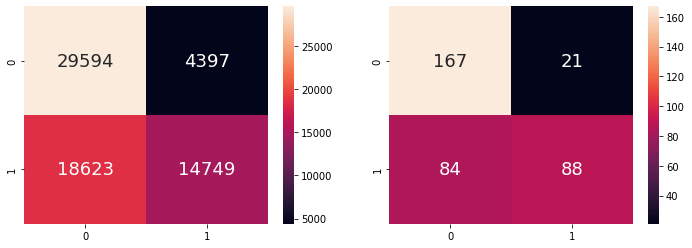

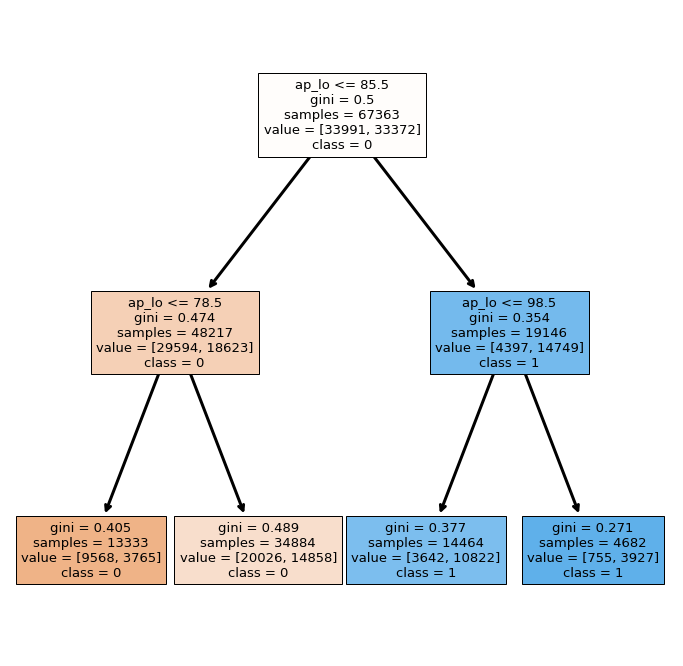

In [ ]:
# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 2)

# Extract Response and Predictors
y = pd.DataFrame(df['cardio'])
X = pd.DataFrame(df['ap_lo'])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 360)
# Train the Decision Tree Classifier model
dectree.fit(X_train, y_train)
        
        
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))

# Plot the Confusion Matrix for Train and Test
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)      
        
plt.show()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5982661104760774
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6111111111111112


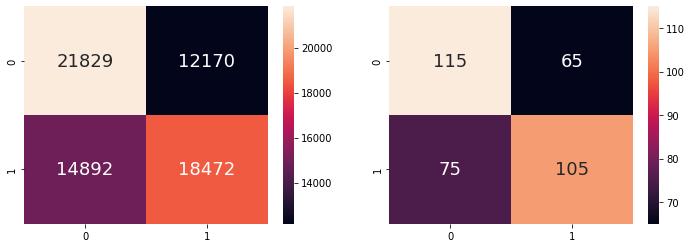

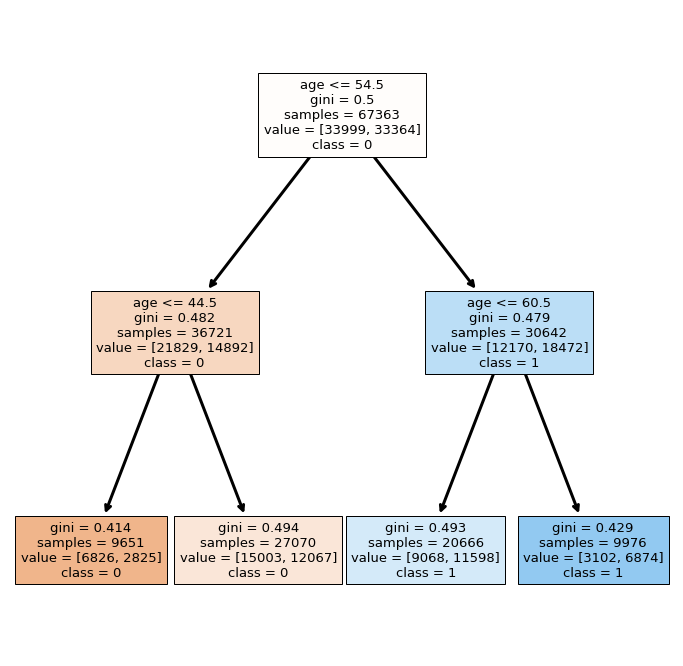

In [ ]:
# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 2)

# Extract Response and Predictors
y = pd.DataFrame(df['cardio'])
X = pd.DataFrame(df['age'])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 360)
# Train the Decision Tree Classifier model
dectree.fit(X_train, y_train)
        
        
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))

# Plot the Confusion Matrix for Train and Test
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)      
        
plt.show()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5912296067574188
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5944444444444444


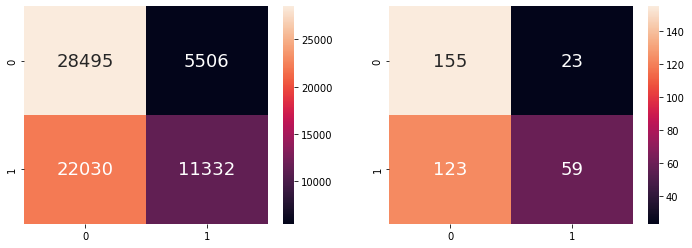

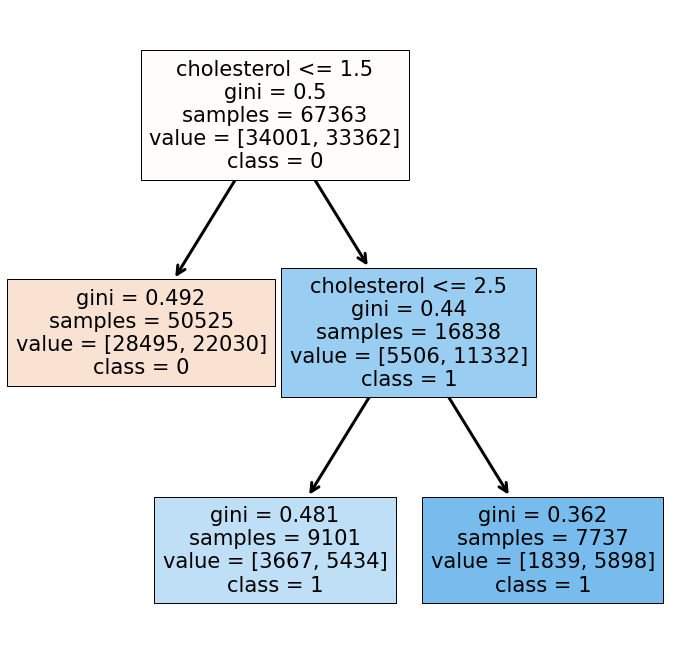

In [ ]:
# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 2)

# Extract Response and Predictors
y = pd.DataFrame(df['cardio'])
X = pd.DataFrame(df['cholesterol'])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 360)
# Train the Decision Tree Classifier model
dectree.fit(X_train, y_train)
        
        
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))

# Plot the Confusion Matrix for Train and Test
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)      
        
plt.show()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6995531671689206

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6666666666666666



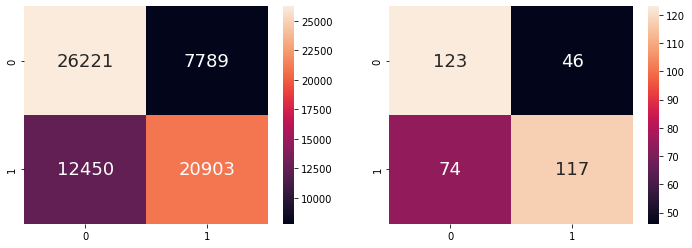

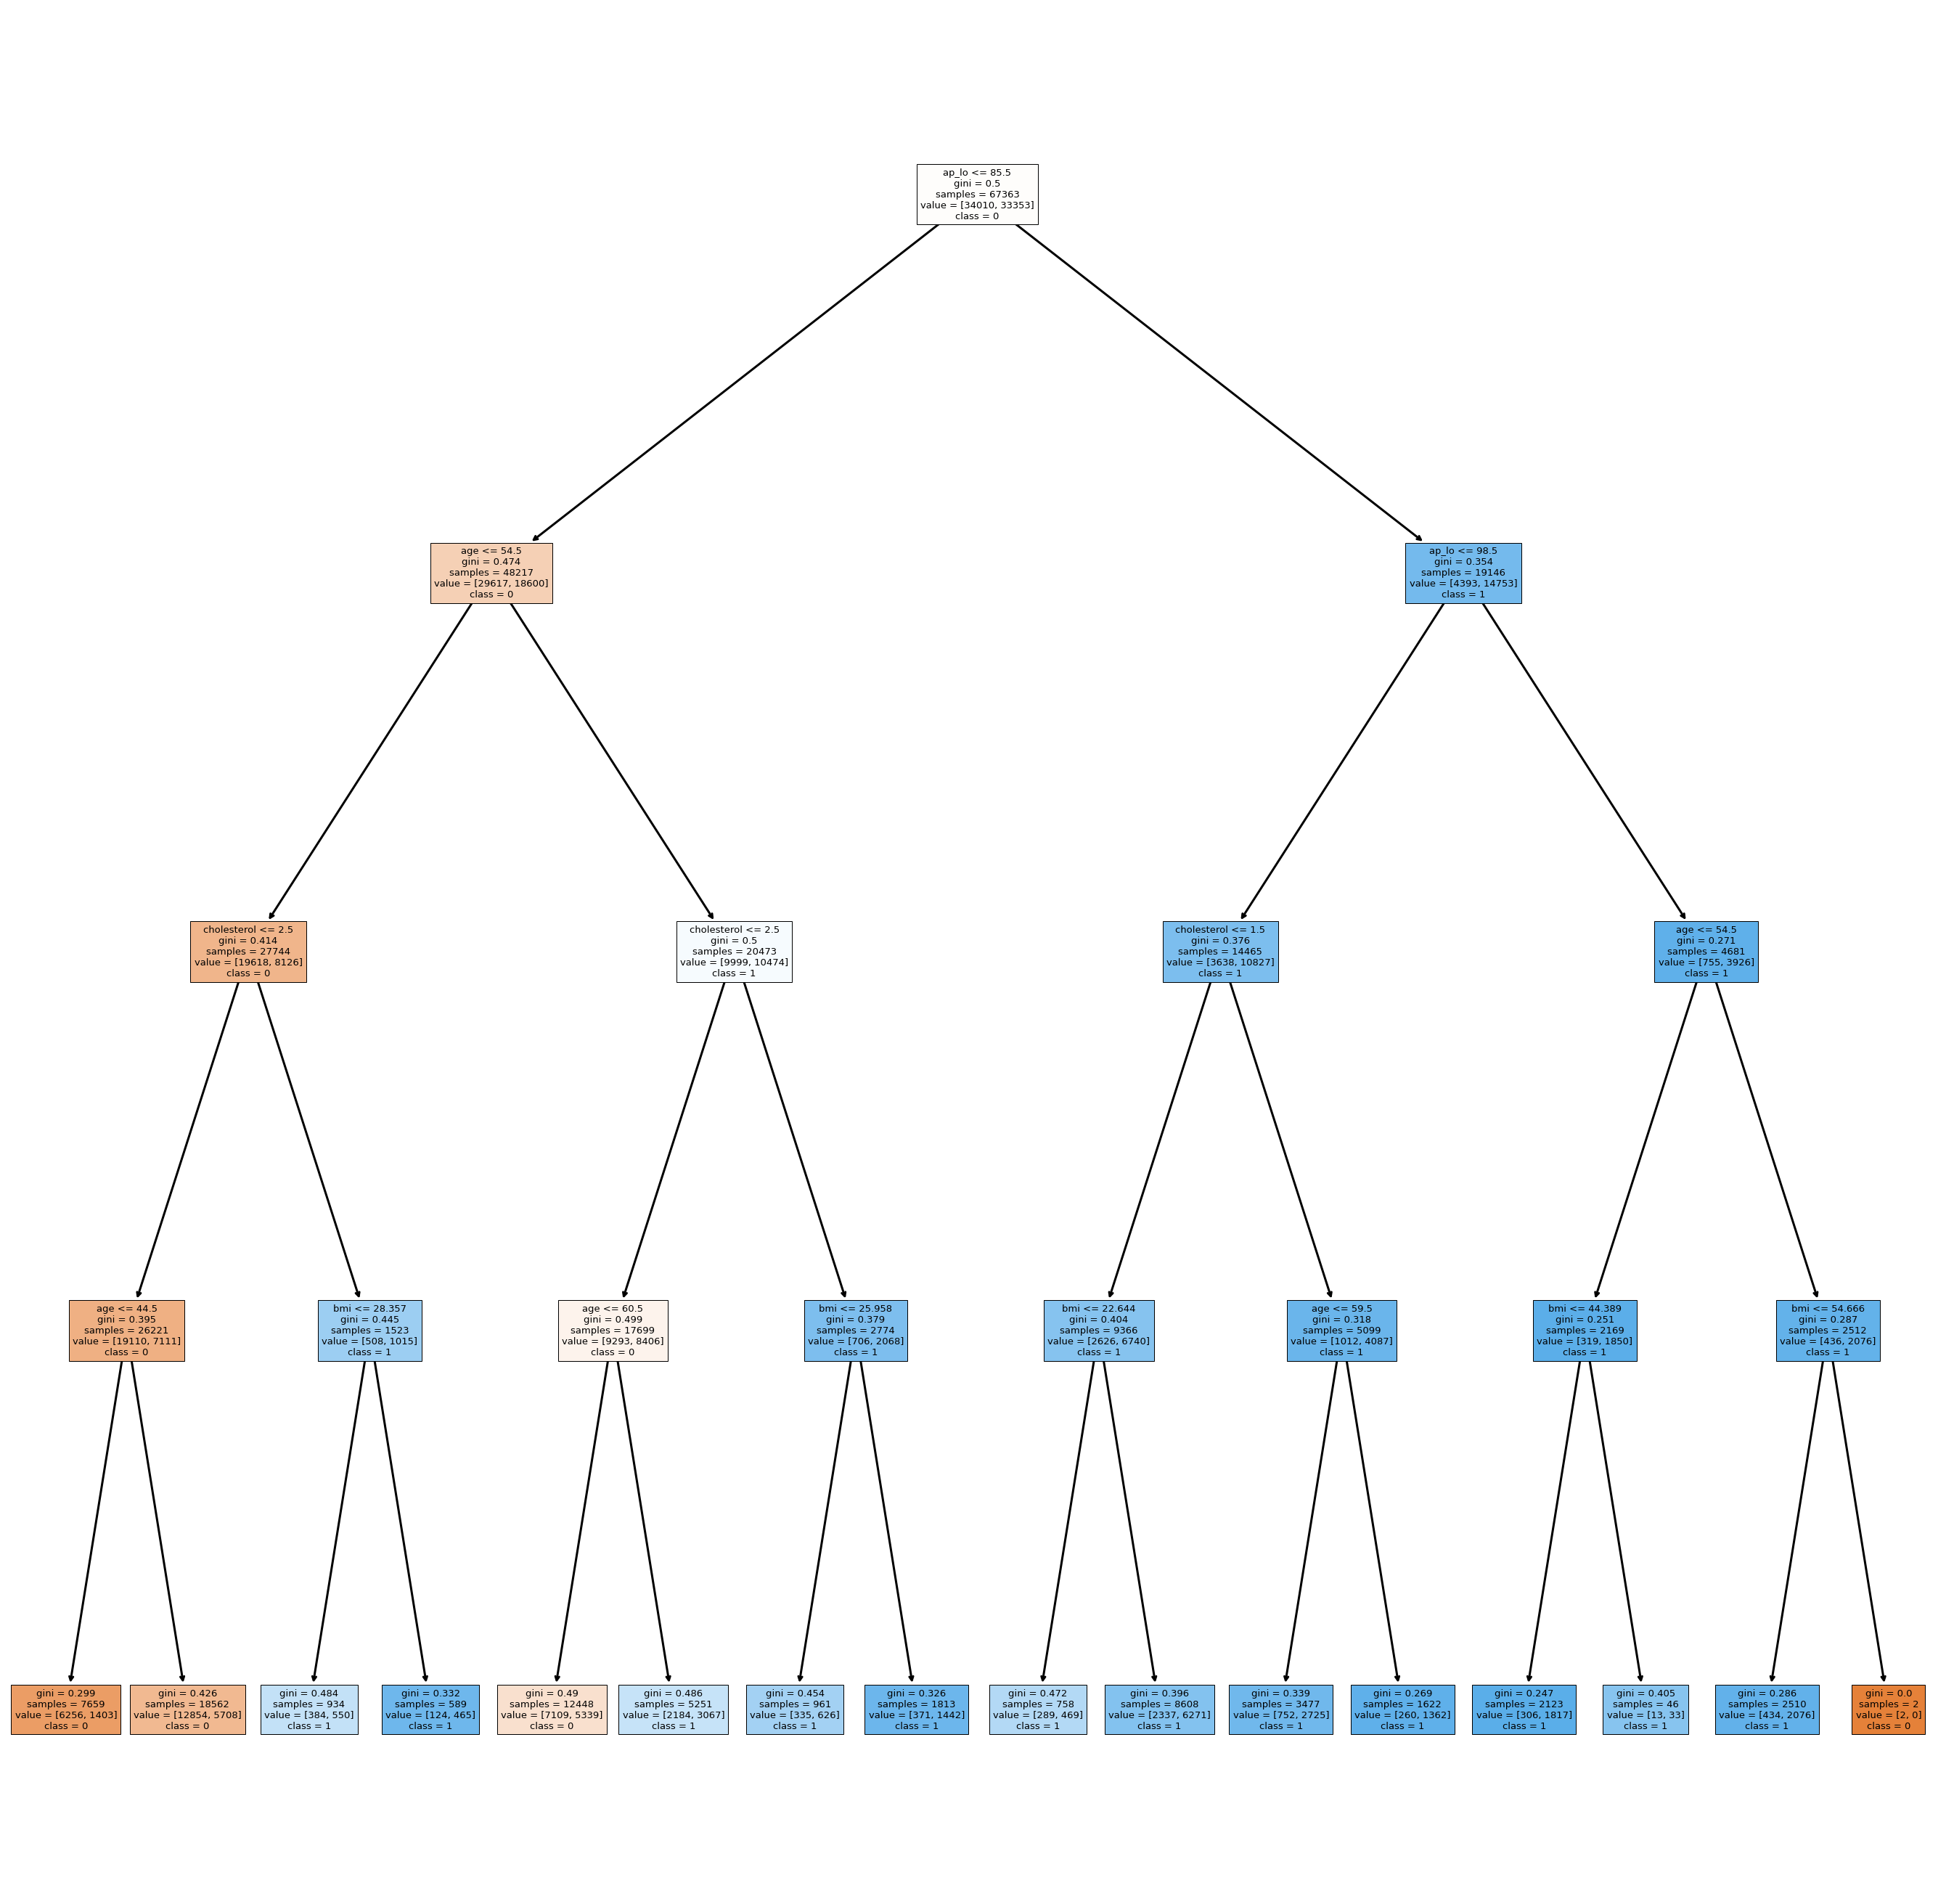

In [ ]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
y = pd.DataFrame(df['cardio'])
X = pd.DataFrame(df[['age', 'ap_lo', 'cholesterol','bmi']])
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 360)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(48, 48))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

In [ ]:
df = pd.get_dummies(df, columns=['blood_pressure_level'])
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,weight_category,blood_pressure_level_High_Normal,blood_pressure_level_Normal,blood_pressure_level_Stage_1_Hypertension,blood_pressure_level_Stage_2_Hypertension
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,Normal,0,1,0,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Obese,0,0,1,0
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Overweight,1,0,0,0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Overweight,0,0,1,0
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,Overweight,0,1,0,0


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7931802324718317

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.75



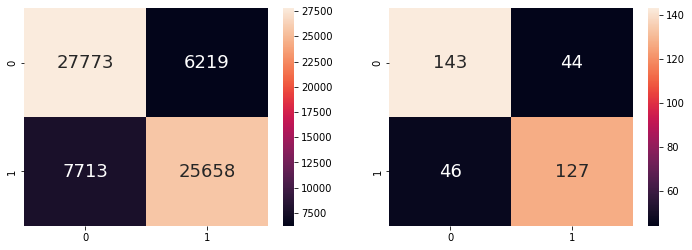

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(df['cardio'])
X = pd.DataFrame(df[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol','gluc','smoke','alco','active','bmi',
                     'blood_pressure_level_High_Normal','blood_pressure_level_Normal', 'blood_pressure_level_Stage_1_Hypertension', 'blood_pressure_level_Stage_2_Hypertension']])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 360)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 15)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

#acc_perceptron = round(dectree.score(X_train, y_train) * 100, 2)
#print(acc_perceptron)


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


# Plot the Decision Tree
#from sklearn.tree import plot_tree
#fig, ax = plt.subplots(figsize=(48, 48))
#out = plot_tree(dectree, 
#          feature_names = X_train.columns,
#          class_names = [str(x) for x in dectree.classes_],
#          filled=True)

#for o in out:
#    arrow = o.arrow_patch
#    if arrow is not None:
#       arrow.set_edgecolor('black')
#        arrow.set_linewidth(3)
        
#plt.show()

Drop id, gender, height, ap_hi, gluc, smoke, alco & active due to correlation with cardio < 0.1 based on Correlation matrix

Drop weight & weight_category due to BMI (calculated from Height & Weight having a higher correlation)

Factors taken into consideration: age, ap_lo, cholesterol, blood_pressure_level & bmi

In [ ]:
df = df.drop(['gender','height','ap_hi','gluc','smoke','alco','active','weight','weight_category'],axis=1)

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(df["cardio"])
X = pd.get_dummies(df[["age", "ap_lo", "cholesterol", "blood_pressure_level", "bmi"]])
X.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, np.ravel(y_train,order="c"))
rf_pre=rf.predict(X_test)
rf.score(X_test,y_test)

In [ ]:
y_train_pred = cross_val_predict(rf, X_train, np.ravel(y_train,order="c"), cv=5)
con=confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(con,fmt=".0f", annot=True,linewidths=0.2, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actually")

In [ ]:
print(classification_report(y_test,rf_pre))

KNN

In [ ]:
k_range = list(range(1, 101))
score = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(y_train,order="c"))
    score.append(knn.score(X_test,y_test))
# m is the best value of n_neighbors 
m=scores.index(max(scores))+1
#plot graph showing percentage of accuracy by number of neighbors
f, ax = plt.subplots(figsize = (6,5))
ax.plot(k_range, scores)
ax.axvline(m, ls='--',ymax=max(scores)+0.2,c='r',solid_capstyle='round')
ax.text(x=m+2,y=0.66,s=m,fontsize=22)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=m)
knn.fit(X_train, np.ravel(y_train,order="c"))
knn_pre=knn.predict(X_test)
knn.score(X_test,y_test)

In [ ]:
y_train_pred = cross_val_predict(knn, X_train, np.ravel(y_train,order="c"), cv=5)
con=confusion_matrix(y_train, y_train_pred)

#plot confusion_matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(con,fmt=".0f", annot=True,linewidths=0.2, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actually")

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8),sharex=True)

plot_roc_curve(knn, X_test, y_test,ax=ax1)
plot_roc_curve(rf, X_test, y_test,ax=ax1,linestyle=':')
plot_roc_curve(dum, X_test, y_test,ax=ax1,linestyle='--')
plot_precision_recall_curve(knn, X_test, y_test,ax=ax2)
plot_precision_recall_curve(rf, X_test, y_test,ax=ax2,linestyle=':')
plot_precision_recall_curve(dum, X_test, y_test,ax=ax2,linestyle='--')
ax1.set_title('ROC curve')
ax2.set_title('precision-recall curve')
plt.show()